In [65]:
import numpy as np
import pandas as pd

from globalbonds.dataio.data_lib import DataLib
from globalbonds.indicators.data_utils import *
from globalbonds.indicators.signal import Signal
from globalbonds.indicators.indicator import Indicator
from globalbonds.indicators.assess_signal import predictive_accuracy
from globalbonds.indicators.return_utils import *
from globalbonds.indicators.normalization import *


from plotnine import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

COUNTRIES = ['USA', 'JPN', 'AUS', 'DEU']
COUNTRIES = ['JPN', 'CAN', 'ESP', 'DEU', 'ITA', 'GBR', 'NOR', 'AUS', 'USA', 'SWE']

dlib = DataLib('../SignalData')


def mask(tbl):
    tbl = tbl[COUNTRIES]
    #tbl = tbl.loc['1980-01-01':'2010-01-01']
    return tbl

bond_returns = mask(dlib.pull('BondRetIdx-LocalFX')).resample('Q').mean()

cash_rate = dlib.pull('RiskFree-Rate')['USA']  # Pull Ticker USGBILL3
cash_rate = cash_rate / 100  # convert cash rate into fraction
cash_rate = cash_rate.map(lambda r: (1 + r) ** (1 / 4) - 1)  # convert annualized cash rate to quarterly
cash_rate = cash_rate.resample('Q').apply(lambda x: x[0])  # get rate at start of each quarter  

def calc_signal_returns(bond_returns, signal, signal_weights=1):
    """Return a Series of returns (as fraction of initial investment) for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    signal_returns = bond_returns * signal
    signal_returns = signal_returns.sum(axis=1) 
    signal_returns -= cash_rate
    signal_returns *= signal_weights
    signal_returns += 1
    signal_returns = signal_returns.cumprod()
    return signal_returns



dlib.list()

['GDP-Real',
 'EquityPrices',
 'LongRates',
 'CurrAcctNom-inUSD',
 'CoreCPI-SA',
 'fxTrdWts-Real',
 'M3-inUSD',
 'RiskFree-Rate',
 'CurrAcctPctGDP',
 'fxTrdWts-Nominal',
 'BondRetIdx-LocalFX',
 'fxVsUSD',
 'M2-inUSD',
 'M1-inUSD',
 'ShortRates',
 'GDP-Nominal']

In [66]:
cash_rate

date
1980Q1    0.028554
1980Q2    0.025693
1980Q3    0.020369
1980Q4    0.031527
1981Q1    0.035062
            ...   
2019Q3    0.005061
2019Q4    0.003754
2020Q1    0.003779
2020Q2    0.000225
2020Q3    0.000225
Freq: Q-DEC, Name: USA, Length: 163, dtype: float64

In [67]:

(cash_rate + 1).cumprod()

date
1980Q1    1.028554
1980Q2    1.054980
1980Q3    1.076469
1980Q4    1.110407
1981Q1    1.149341
            ...   
2019Q3    5.231015
2019Q4    5.250651
2020Q1    5.270491
2020Q2    5.271676
2020Q3    5.272862
Freq: Q-DEC, Name: USA, Length: 163, dtype: float64

In [68]:

def foo(bond_returns, signal):
    """Return a Series of returns (as fraction of initial investment) for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    bond_returns = bond_returns.fillna(0)
    bond_returns += 1

    signal_returns = bond_returns * signal
    signal_returns = (signal_returns.sum(axis=1) + 1)
    #signal_returns.index = signal_returns.index.to_timestamp()
    return signal_returns
    signal_returns -= cash_rate
    return signal_returns
    signal_returns = signal_returns.cumprod()
    return signal_returns

foo(bond_returns, gdp.data.resample('Q').mean())

date
1980Q1     1.000000
1980Q2     1.000000
1980Q3     1.000000
1980Q4     1.000000
1981Q1     1.000000
            ...    
2019Q3     1.104247
2019Q4     0.285382
2020Q1    -3.044841
2020Q2   -13.524505
2020Q3     1.000000
Freq: Q-DEC, Length: 163, dtype: float64

In [69]:
def foo(bond_returns, signal):
    """Return a Series of returns (as fraction of initial investment) for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    bond_returns = bond_returns.fillna(0)
    bond_returns += 1

    signal_returns = bond_returns * signal
    signal_returns = (signal_returns.sum(axis=1) + 1)
    #signal_returns.index = signal_returns.index.to_timestamp()
    #return signal_returns
    signal_returns /= cash_rate
    return signal_returns
    signal_returns = signal_returns.cumprod()
    return signal_returns

foo(bond_returns, gdp.data.resample('Q').mean())

date
1980Q1       35.021863
1980Q2       38.921479
1980Q3       49.093845
1980Q4       31.718396
1981Q1       28.520537
              ...     
2019Q3      218.168420
2019Q4       76.024717
2020Q1     -805.826953
2020Q2   -60129.195419
2020Q3     4445.944163
Freq: Q-DEC, Length: 163, dtype: float64

In [70]:
def foo(bond_returns, signal):
    """Return a Series of returns (as fraction of initial investment) for a signal."""
    signal = signal.copy().fillna(0)
    bond_returns = bond_returns.pct_change()
    bond_returns = bond_returns.fillna(0)
    bond_returns += 1

    signal_returns = bond_returns * signal
    signal_returns = (signal_returns.sum(axis=1) + 1)

    signal_returns = signal_returns.cumprod()
    return signal_returns

foo(bond_returns, gdp.data.resample('Q').mean())

date
1980Q1      1.000000
1980Q2      1.000000
1980Q3      1.000000
1980Q4      1.000000
1981Q1      1.000000
             ...    
2019Q3    -31.741620
2019Q4     -9.058499
2020Q1     27.581692
2020Q2   -373.028745
2020Q3   -373.028745
Freq: Q-DEC, Length: 163, dtype: float64

In [71]:
gdp = mask(dlib.pull('GDP-Real'))
gdp = derivative(gdp, s=1).rolling(3).mean()
gdp = Signal('GDP', gdp)

gdp_sig = signalize(gdp.data.resample('Q').mean())
gdp_returns = calc_signal_returns(bond_returns, gdp_sig)
gdp_returns

date
1980Q1    0.971446
1980Q2    0.946487
1980Q3    0.927208
1980Q4    0.897976
1981Q1    0.866490
            ...   
2019Q3    0.169253
2019Q4    0.170584
2020Q1    0.178239
2020Q2    0.160360
2020Q3    0.160324
Freq: Q-DEC, Length: 163, dtype: float64

In [72]:
eqs = mask(dlib.pull('EquityPrices')).resample('Q').mean().iloc[1:]
eqs = eqs.rolling(4).apply(lambda x: x[3] / x[:3].max()).applymap(lambda x: x - 1)
eqs = Signal('Equity Prices', eqs, normalizer=lambda x: x)

eqs_sig = signalize(eqs.data.resample('Q').mean())
eqs_returns = calc_signal_returns(bond_returns, eqs_sig)
eqs_returns

/home/dcdanko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


date
1980Q1    0.971446
1980Q2    0.946487
1980Q3    0.927208
1980Q4    0.897976
1981Q1    0.874740
            ...   
2019Q3    0.374199
2019Q4    0.381548
2020Q1    0.399431
2020Q2    0.439815
2020Q3    0.431261
Freq: Q-DEC, Length: 163, dtype: float64

In [73]:
mom_sig = get_momentum_signal(bond_returns).iloc[1:]
mom_returns = calc_signal_returns(bond_returns, mom_sig)
mom_returns

/home/dcdanko/Dev/Internship2020/globalbonds/globalbonds/indicators/return_utils.py:21: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  momentum_signal = momentum_signal.rolling(window).apply(lambda x: x[:window - 1].mean())


date
1980Q1    0.971446
1980Q2    0.946487
1980Q3    0.927208
1980Q4    0.897976
1981Q1    0.887604
            ...   
2019Q3    1.485973
2019Q4    1.535280
2020Q1    1.518003
2020Q2    1.536046
2020Q3    1.493253
Freq: Q-DEC, Length: 163, dtype: float64

In [74]:
pick_gdp = gdp_sig.apply(extremity, axis=1) > eqs_sig.apply(extremity, axis=1)
ext_sig = eqs_sig.copy()
ext_sig[pick_gdp] = gdp_sig[pick_gdp]

ext_returns = calc_signal_returns(bond_returns, ext_sig)
ext_returns


date
1980Q1    0.971446
1980Q2    0.946487
1980Q3    0.927208
1980Q4    0.897976
1981Q1    0.874740
            ...   
2019Q3    0.360346
2019Q4    0.367423
2020Q1    0.384644
2020Q2    0.423533
2020Q3    0.415295
Freq: Q-DEC, Length: 163, dtype: float64

In [75]:
pick_ext = gdp_sig.apply(extremity, axis=1) > eqs_sig.apply(extremity, axis=1)
ext3_sig = mom_sig.copy()
ext3_sig[pick_ext] = gdp_sig[pick_ext]

ext3_returns = calc_signal_returns(bond_returns, ext3_sig)
ext3_returns

date
1980Q1    0.971446
1980Q2    0.946487
1980Q3    0.927208
1980Q4    0.897976
1981Q1    0.887604
            ...   
2019Q3    1.278094
2019Q4    1.320504
2020Q1    1.305643
2020Q2    1.321162
2020Q3    1.284355
Freq: Q-DEC, Length: 163, dtype: float64

In [76]:
pick_ext = eqs_sig.apply(extremity, axis=1) > mom_sig.apply(extremity, axis=1)
print(pick_ext.sum())
ext4_sig = mom_sig.copy()
ext4_sig[pick_ext] = eqs_sig[pick_ext]

ext4_returns = calc_signal_returns(bond_returns, ext4_sig)
ext4_returns

88


date
1980Q1    0.971446
1980Q2    0.946487
1980Q3    0.927208
1980Q4    0.897976
1981Q1    0.887604
            ...   
2019Q3    1.781251
2019Q4    1.816237
2020Q1    1.901362
2020Q2    2.093597
2020Q3    2.052878
Freq: Q-DEC, Length: 163, dtype: float64

In [77]:
pick_ext = ext_sig.apply(extremity, axis=1) > mom_sig.apply(extremity, axis=1)
print(pick_ext.sum())
ext5_sig = mom_sig.copy()
ext5_sig[pick_ext] = ext_sig[pick_ext]

ext5_returns = calc_signal_returns(bond_returns, ext5_sig)
ext5_returns

92


date
1980Q1    0.971446
1980Q2    0.946487
1980Q3    0.927208
1980Q4    0.897976
1981Q1    0.887604
            ...   
2019Q3    1.563544
2019Q4    1.594253
2020Q1    1.668974
2020Q2    1.837714
2020Q3    1.801972
Freq: Q-DEC, Length: 163, dtype: float64

/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


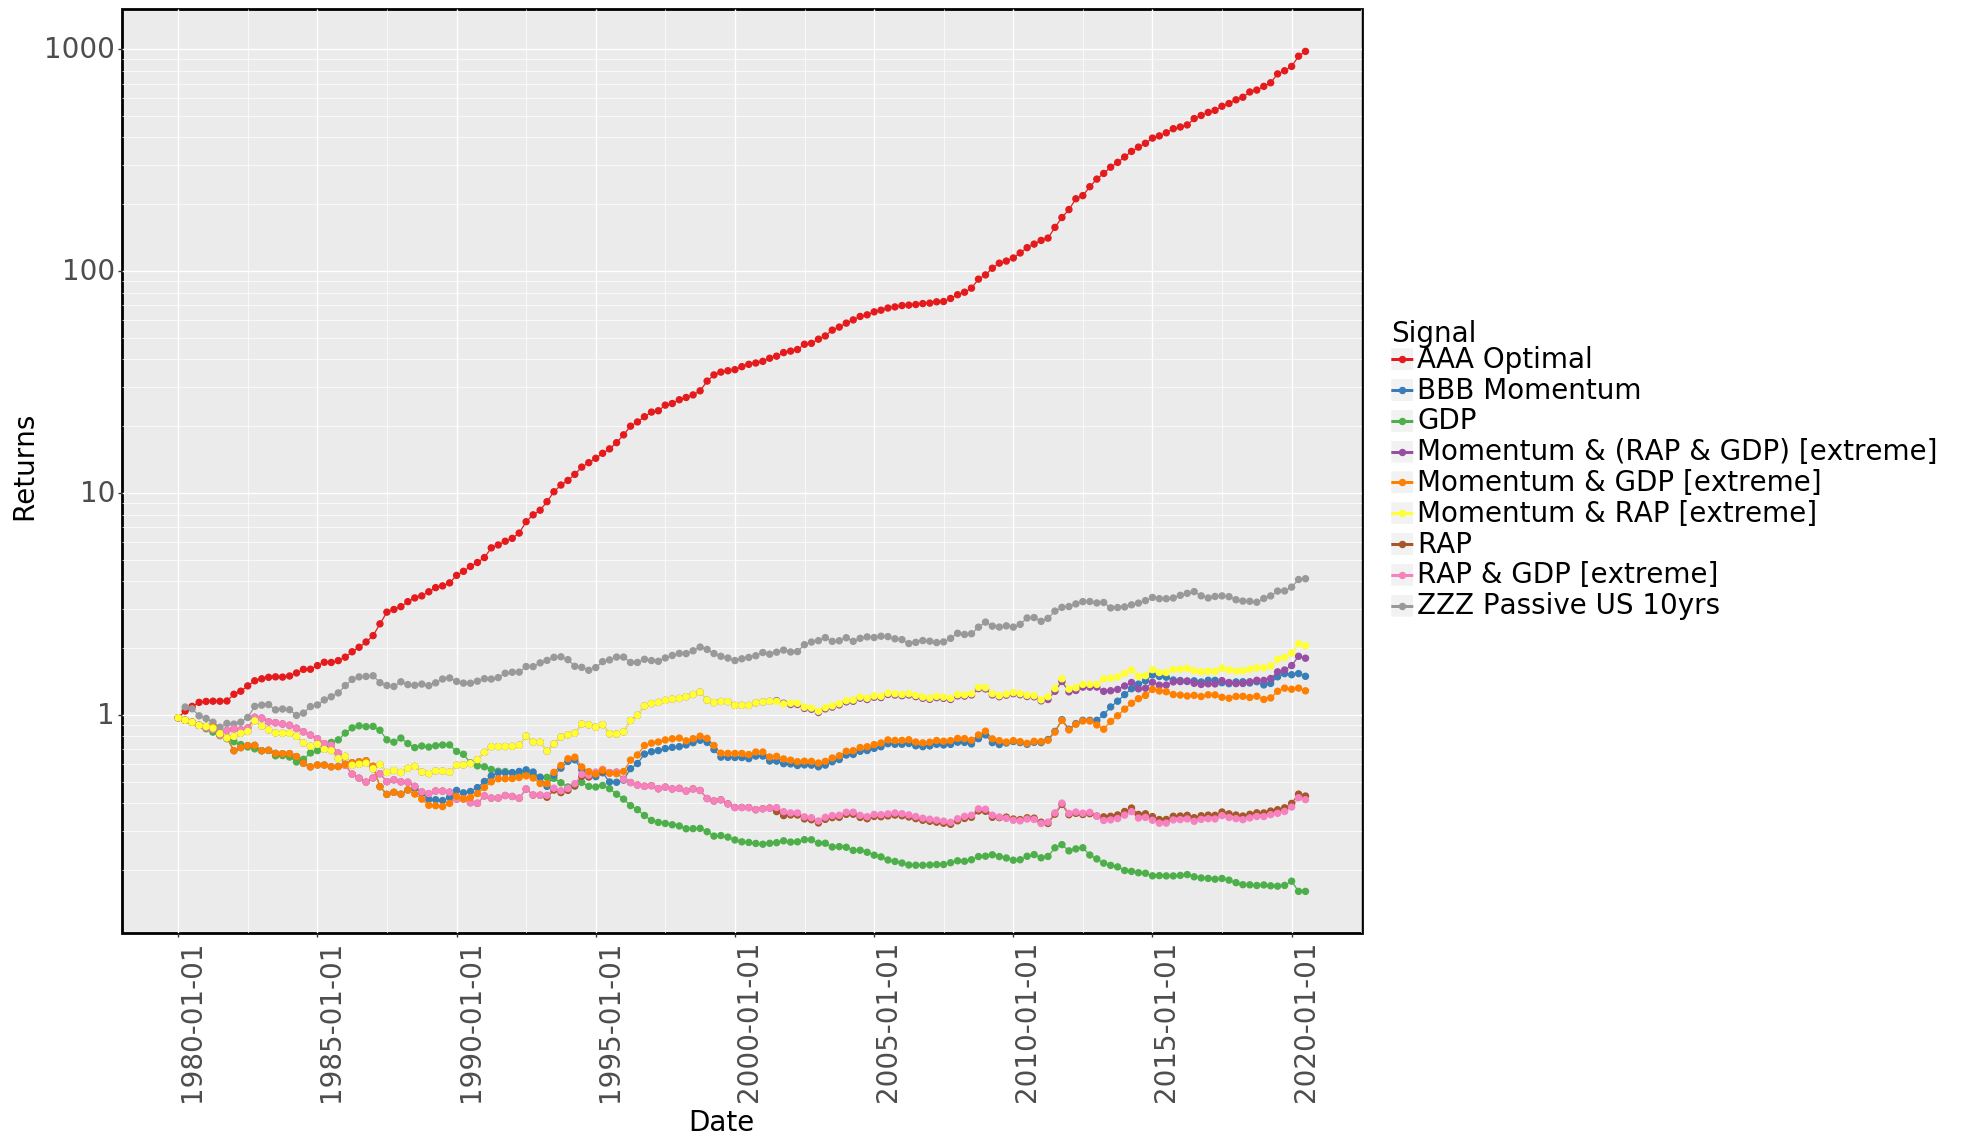

<ggplot: (8760395502733)>

In [78]:
def get_risk_free_return(bond_returns):
    risk_free_returns = bond_returns['USA'].pct_change() + 1
    risk_free_returns /= (1 + cash_rate)
    risk_free_returns = risk_free_returns.cumprod()
    return risk_free_returns

df = {
    'GDP': gdp_returns,
    'AAA Optimal': calc_signal_returns(bond_returns, get_optimal_signal(bond_returns)),
    'BBB Momentum': mom_returns,
    'RAP': eqs_returns,
    'ZZZ Passive US 10yrs': get_risk_free_return(bond_returns),
    'RAP & GDP [extreme]': ext_returns,
    'Momentum & (RAP & GDP) [extreme]': ext5_returns,
    'Momentum & GDP [extreme]': ext3_returns,
    'Momentum & RAP [extreme]': ext4_returns,

}
# for i in range(5):
#     df[f'random {i}'] = calc_signal_returns(bond_returns, get_random_signal(bond_returns))
#df = {k: v - cash_rate for k, v in df.items()}
df = pd.DataFrame(df)
df['date'] = df.index.to_series().map(lambda x: x.to_timestamp())
df = df.melt(id_vars='date')
df['color'] = df['variable'].map(lambda x: x.split()[0] if 'random' in x else x)
(
    ggplot(df, aes(x='date', y='value', color='color')) +
        geom_line(aes(group='variable')) +
        geom_point(aes(group='variable'), size=2) +
        scale_color_brewer(type='qualitative', palette=6) +
        ylab('Returns') +
        xlab('Date') +
        scale_x_date() +
        scale_y_log10() +
        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(16, 12),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

/home/dcdanko/miniconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


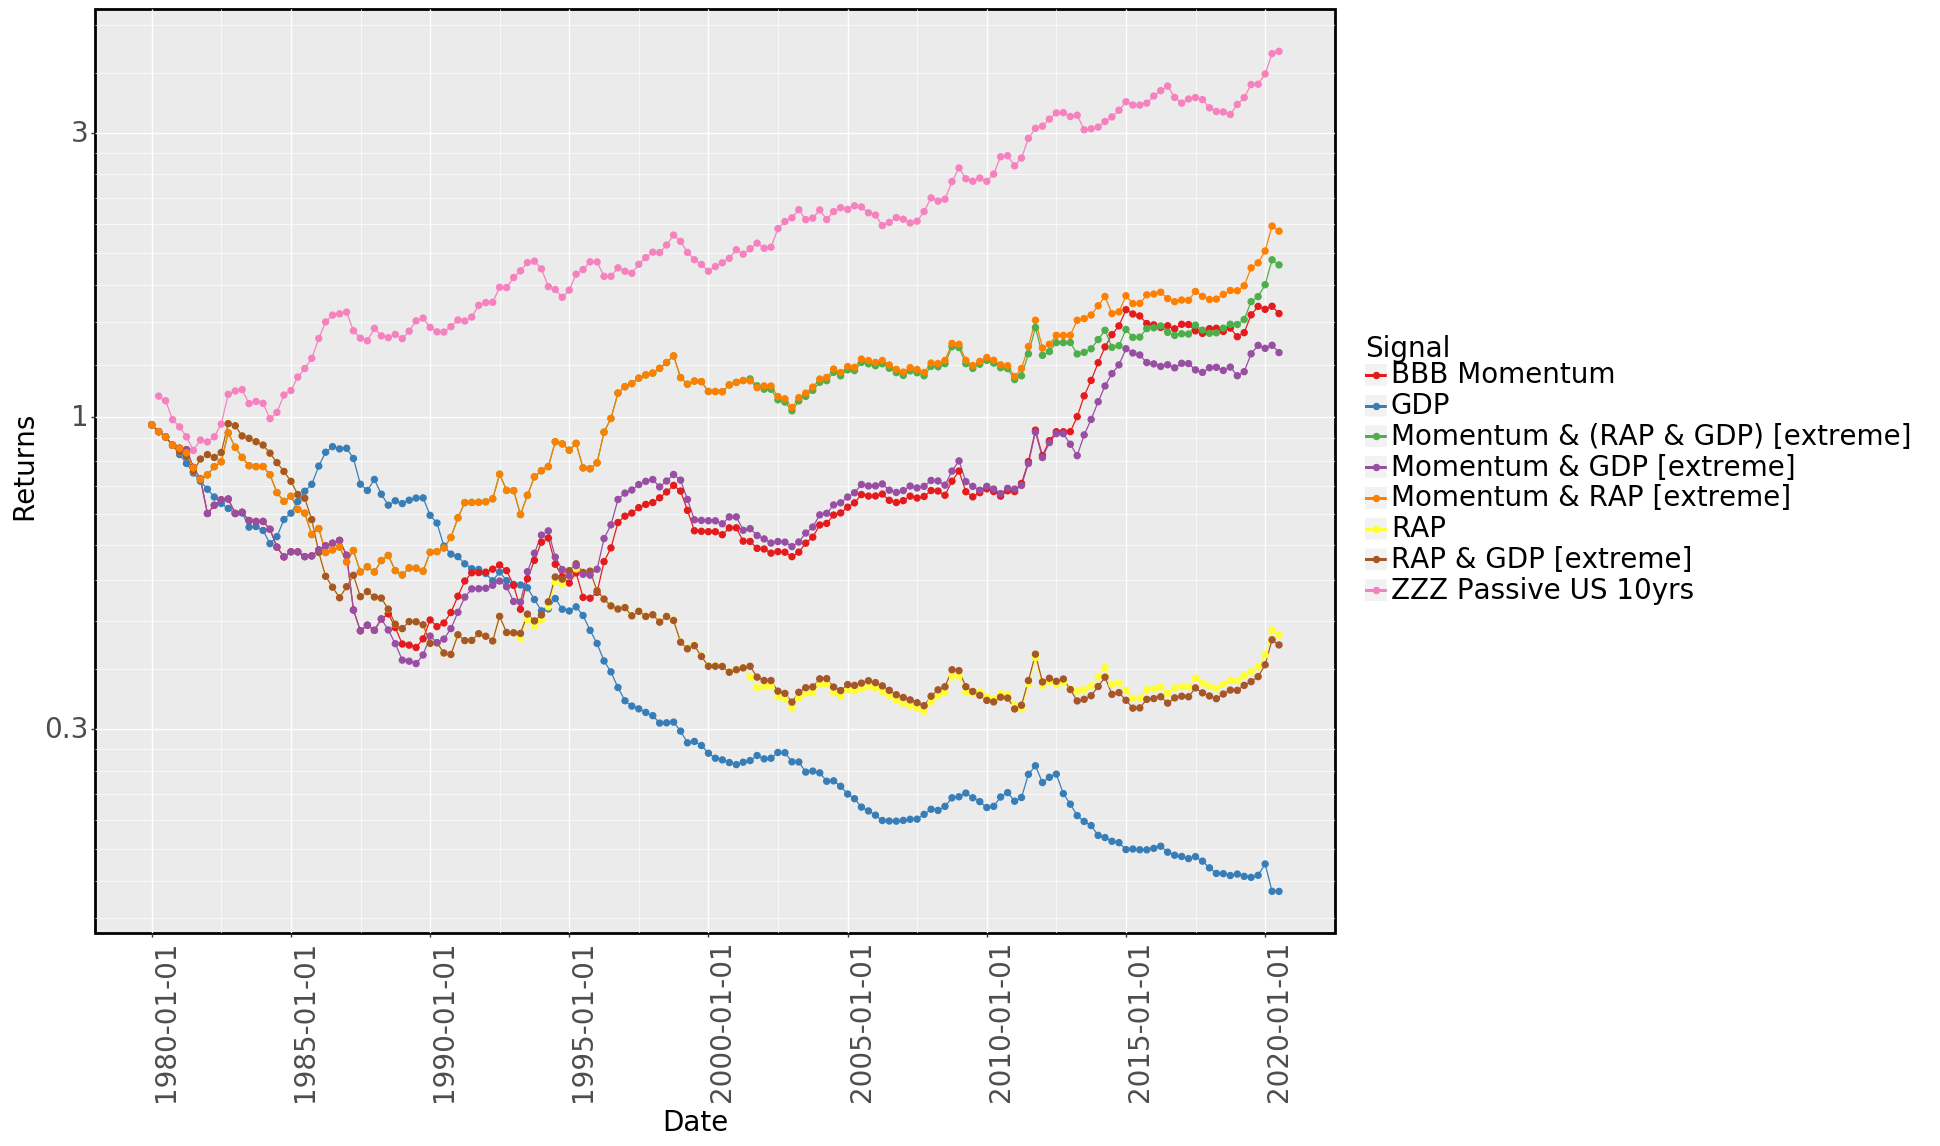

<ggplot: (-9223363276459383727)>

In [79]:
df = {
    'GDP': gdp_returns,
    #'AAA Optimal': calc_signal_returns(bond_returns, get_optimal_signal(bond_returns)),
    'BBB Momentum': mom_returns,
    'RAP': eqs_returns,
    'ZZZ Passive US 10yrs': get_risk_free_return(bond_returns),
    'RAP & GDP [extreme]': ext_returns,
    'Momentum & (RAP & GDP) [extreme]': ext5_returns,
    'Momentum & GDP [extreme]': ext3_returns,
    'Momentum & RAP [extreme]': ext4_returns,

}
# for i in range(5):
#     df[f'random {i}'] = calc_signal_returns(bond_returns, get_random_signal(bond_returns))
#df = {k: v - cash_rate for k, v in df.items()}
df = pd.DataFrame(df)
df['date'] = df.index.to_series().map(lambda x: x.to_timestamp())
df = df.melt(id_vars='date')
df['color'] = df['variable'].map(lambda x: x.split()[0] if 'random' in x else x)
(
    ggplot(df, aes(x='date', y='value', color='color')) +
        geom_line(aes(group='variable')) +
        geom_point(aes(group='variable'), size=2) +
        scale_color_brewer(type='qualitative', palette=6) +
        ylab('Returns') +
        xlab('Date') +
        scale_x_date() +
        scale_y_log10() +
        labs(color='Signal') +
        theme(
            text=element_text(size=20),
            figure_size=(16, 12),
            legend_position='right',
            axis_text_x=element_text(size=20, angle=90, hjust=0),
            panel_border=element_rect(colour="black", size=2),
        )
)

In [41]:
get_risk_free_return(bond_returns)

date
1980Q1         NaN
1980Q2    1.085675
1980Q3    1.066413
1980Q4    0.991146
1981Q1    0.964054
            ...   
2019Q3    3.616092
2019Q4    3.621068
2020Q1    3.767162
2020Q2    4.074949
2020Q3    4.110049
Freq: Q-DEC, Name: USA, Length: 163, dtype: float64

In [203]:
riskfreeRates = dsPuller.ds_country_pull(
    lambda x: f'{x}GBILL3',
    start_date, '', 'M', list(filter(lambda x: x =='USA', countryList))
)

NameError: name 'dsPuller' is not defined

In [ ]:
lib.

In [185]:

class GrowthIndicator:
    
    def __init__(self, eqs, gdp):
        self.streams = {
            'eqs': eqs,
            'gdp': gdp,
        }
        
    @property
    def signals(self):
        return {k: signalize(v).fillna(0) for k, v in self.streams.items()}
    
        
gi = GrowthIndicator(eqs.data, gdp.data.resample('Q').mean())

In [186]:
from scipy.stats import pearsonr, spearmanr

def cor(X, Y):
    X = X.loc[Y.index].dropna()
    Y = Y.loc[X.index]
    out = {}
    for var in set(X.columns) & set(Y.columns):
        out[var] = pearsonr(X[var], Y[var])[0]
    return out

cor(gi.signals['eqs'], gi.signals['gdp'])

{'AUS': 0.10367720730213896,
 'USA': -0.150005742701549,
 'JPN': -0.02916503979372155,
 'DEU': 0.0543495584174931}

In [187]:
cor(gi.signals['eqs'], mom_sig.fillna(0))

{'AUS': 0.31617604508679387,
 'USA': 0.013629675886154763,
 'JPN': -0.23365465699524032,
 'DEU': 0.0772045801337639}

In [188]:
cor(gi.signals['gdp'], mom_sig.fillna(0))

{'AUS': 0.043201564704132604,
 'USA': -0.13013418539550659,
 'JPN': 0.06348893832737341,
 'DEU': -0.28505434618854125}

date
1980-01       NaN
1980-02       NaN
1980-03    0.1463
1980-04    0.1463
1980-05    0.1435
            ...  
2020-04    0.0125
2020-05    0.0014
2020-06    0.0016
2020-07    0.0016
2020-08    0.0016
Freq: M, Name: USA, Length: 488, dtype: float64